<a href="https://colab.research.google.com/github/Dain777666/ESAA_25-2/blob/main/OB_WEEK1_FRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 4.5 규제가 있는 선형 모델

- 선형 회귀 -> 모델의 가중치를 제한하여 규제를 가함

- 규제가 추가된 선형 회귀: 릿지 회귀, 라쏘 회귀, 엘라스틱넷

- 다항 회귀 -> 다항식의 차수를 감소시켜 규제를 가함

### 4.5.1 릿지 회귀

- <규제항>

  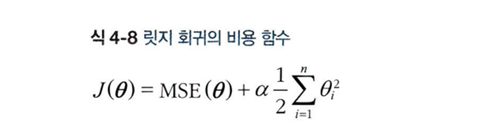

- 모델의 가중치가 가능한 작게 유지되도록 함

- 모델 훈련시에만 규제항이 추가되고, 성능을 평가할 때는 사용하지 않음

- 하이퍼파라미터 alpha: 모델을 얼마나 많이 규제할지 조절

- 편향은 규제되지 않음

- 입력 특성의 스케일에 민감하기 때문에 데이터의 스케일을 맞추는 것이 중요함(규제가 있는 모델은 대부분 마찬가지)


In [19]:
import numpy as np
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

In [20]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([5.14827287])

In [21]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(penalty="l2") # 릿지 회귀
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([5.14641954])

### 4.5.2 라쏘 회귀

- <규제항>

  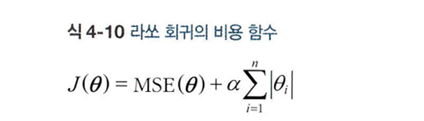

- 덜 중요한 특성의 가중치를 제거함

- 라쏘의 비용 함수는 theta가 0일 때 미분가능하지 않음 -> 따라서, 서브그레이디언트 벡터 이용



In [22]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X,y)
lasso_reg.predict([[1.5]])

array([5.10282728])

### 4.5.3 엘라스틱넷

- 릿지 회귀와 라쏘 회귀를 절충한 모델

- <규제항>

  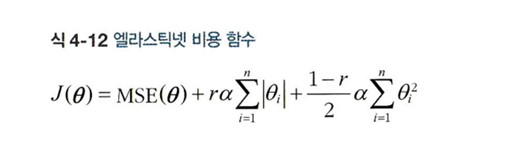

- 규제항의 혼합 정도는 혼합 비율 r을 사용해 조절함

- 특성 수가 훈련 샘플 수보다 많거나 특성 몇 개가 강하게 연관되어 있을 때는 보통 라쏘가 문제를 일으키므로 엘라스틱넷을 선호함

In [23]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5) # l1_ratio가 혼합 비율 r
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([5.09810604])

### 4.5.4 조기 종료

- 검증 에러가 최솟값에 도달하면 바로 훈련을 중지시키는 것

- 확률적 경사 하강법이나 미니배치 경사 하강법에서는 곡선이 매끄럽지 않아 최솟값에 도달했는지 확인 어려움 -> 검증 에러가 일정 시간 동안 최솟값보다 클 때 학습을 멈추고 검증 에러가 최소였을 때의 모델 파라미터로 되돌림

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [25]:
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# 데이터 준비
poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
    ("std_scaler", StandardScaler())
])
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=None, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train.ravel()) # 훈련을 이어서 진행합니다.
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
      minimum_val_error = val_error
      best_epoch = epoch
      best_model = clone(sgd_reg)

### 4.6 로지스틱 회귀

- 어떤 회귀 알고리즘은 분류에서도 사용할 수 있음

### 4.6.1 확률 추정

- 로지스틱 회귀: 입력 특성의 가중치 합을 계산하여 편향을 더함, 대신 선형 회귀처럼 바로 결과를 출력하지 않고 결괏값의 로지스틱을 출력함

- 로지스틱: 0과 1사이의 값을 출력하는 시그모이드 함수

- <시그모이드 함수>

  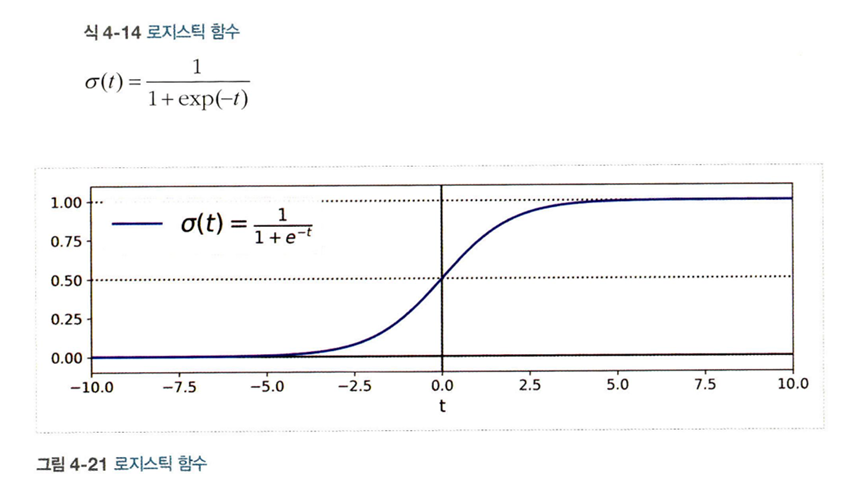

- t<0 이면 음성클래스라고 예측, t>0 이면 양성클래스라고 예측



### 4.6.2 훈련과 비용 함수

- 훈련: 양성 샘플(y=1)에 대해서는 높은 확률을 추정하고 음성 샘플(y=0)에 대해서는 낮은 확률을 추정하는 모델의 파라미터 벡터를 찾는 것

  < y=1인 경우 >

- 비용 함수: -log(H(x)), 이때 H(x)는 시그모이드 함수

- 모델이 예측한 확률 H(x)가 1에 가까워질수록, -log(H(x)) 값은 0에 수렴(비용 감소)

- 예측 확률이 0에 가까워질수록, -log(H(x)) 값은 무한대로 발산(비용 급증)

  < y=0인 경우 >

- 비용 함수: −log(1−H(x))

- 모델이 예측한 확률 H(x)가 0에 가까워질수록, -log(1-H(x)) 값은 0에 수렴(비용 감소)

- 예측 확률이 1에 가까워질수록, -log(1-H(x)) 값은 무한대로 발산(비용 급증)

### 4.6.3 결정 경계



In [26]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [27]:
X = iris["data"][:, 3:] # 꽃잎의 너비
y = (iris["target"] == 2).astype(int) # Iris-Virginica면 1, 그렇지 않으면 0

In [28]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

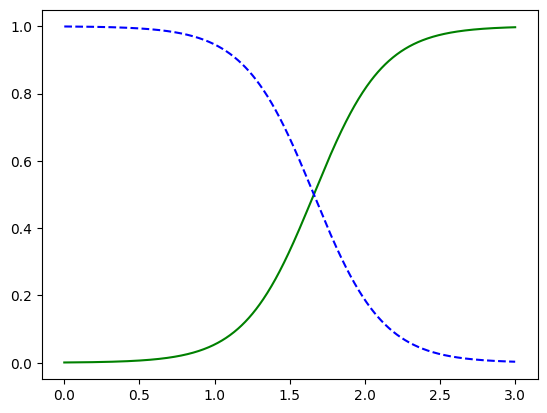

In [29]:
import matplotlib.pyplot as plt

X_new = np.linspace(0, 3, 1000).reshape(-1,1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:, 1], "g-", label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", label="Not Iris virginica")

In [30]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

### 4.6.4 소프트맥스 회귀

- 로지스틱 회귀 모델은 직접 다중 클래스를 지원하도록 일반화할 수 있음 -> 소프트맥스 회귀 또는 다항 로지스틱 회귀라고 함

- 샘플 x가 주어지면 먼저 소프트맥스 회귀 모델이 각 클래스 k에 대한 점수를 계산하고, 그 점수에 소프트맥스 함수를 적용하여 각 클래스의 확률을 추정함

- 다중 클래스지만 다중 출력은 아님

- 크로스 엔트로피: 추정된 클래스의 확률이 타깃 클래스에 얼마나 잘 맞는지 측정하는 용도로 사용됨

- <크로스 엔트로피 비용 함수>

  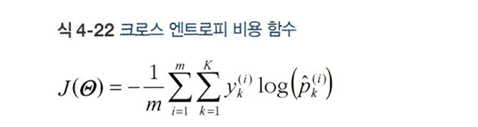



In [32]:
X = iris["data"][:, (2,3)] # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10)
softmax_reg.fit(X, y)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(C=10, multi_class='multinomial')

In [33]:
softmax_reg.predict([[5, 2]])

array([2])

In [34]:
softmax_reg.predict_proba([[5, 2]])

array([[6.21626374e-07, 5.73689802e-02, 9.42630398e-01]])